# Latent Feature Extraction

## 1. Set up the Environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 1.2 MB 5.7 MB/s 


In [ ]:
import logging
import os
import sys
import shutil
import tempfile
import random

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, partition_dataset_classes

In [ ]:
random.seed(123)

In [ ]:
device = torch.device("cuda")

## 2. Connect to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
image_dir = os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data/T2_test_data/imagesTs")
weights_dir = os.path.join(mount_dir, "pretrained_models/MedicalNet_resnet")
results_dir = os.path.join(drive_dir, "Test Data")

Mounted at /content/drive


In [ ]:
# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, the whole model is finetuned.
# When True only the last layer before the fc layer is updated
feature_extract = True

## 3. Create Train and Validation Dataset

In [ ]:
from monai.transforms import (
    Compose,
    ScaleIntensityRanged,
    EnsureTyped,
    LoadImaged,
    AddChanneld,
    Orientationd,
    Resized,
    EnsureType,
    Activations,
    AsDiscrete
)

In [ ]:
# specify transformations that are to be applied
transforms = Compose([
    LoadImaged(keys=["image"]),
    AddChanneld(keys=["image"]),
    Orientationd(keys=["image"], axcodes="PLI"),
    Resized(keys=["image"], spatial_size=(128, 128, 64)),
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image"])])

/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [ ]:
# Create labels
labels = np.concatenate((np.zeros(20, dtype='int64'), np.ones(20, dtype='int64')), axis=0)

# Get image paths
image_paths = [
  os.path.join(image_dir, img)
  for img in os.listdir(image_dir)
]

data = [{"image": i, "label": l} for i, l in zip(image_paths, labels)]

In [ ]:
data_partition = partition_dataset_classes(data, labels.tolist(), shuffle=True, ratios=[0.8, 0.2])

datasets = {x: CacheDataset(data=data_partition[x], transform=transforms) for x in [0, 1]}
dataloaders_dict = {x: DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in [0, 1]}

Loading dataset: 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataloaders_dict['train'] = dataloaders_dict.pop(0)
dataloaders_dict['val'] = dataloaders_dict.pop(1)
dataloaders_dict

{'train': <monai.data.dataloader.DataLoader at 0x7f40b7acb3a0>,
 'val': <monai.data.dataloader.DataLoader at 0x7f40b7acb610>}

## 4. Define Helper Functions

In [ ]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_data in dataloaders[phase]:
                inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        #outputs = model(inputs)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        ct = 0
        for child in model.children():
          ct += 1
          if ct < 8:
            for param in child.parameters():
              param.requires_grad = False

In [ ]:
def initialize_model(num_classes, feature_extract, use_pretrained=False):
  model_ft = monai.networks.nets.resnet50(spatial_dims=3, n_input_channels=1)
  weights_dict = torch.load(os.path.join(weights_dir, "resnet_50_23dataset.pth"))
  weights_dict = {k.replace('module.', ''): v for k, v in weights_dict['state_dict'].items()}
  
  model_dict = model_ft.state_dict()
  model_dict.update(weights_dict)
  model_ft.load_state_dict(model_dict)
  set_parameter_requires_grad(model_ft, feature_extract)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)

  return model_ft

## 5. Initialize the Network with Pretrained Weights

In [ ]:
# Initialize the model for this run
model_ft = initialize_model(num_classes, feature_extract)

## 6. Specify Parameters that Should Be Finetuned  

In [ ]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe all parameters to be optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.conv3.weight
	 layer4.0.bn3.weight
	 layer4.0.bn3.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.0.bias
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 layer4.1.conv3.weight
	 layer4.1.bn3.weight
	 layer4.1.bn3.bias
	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 layer4.2.conv3.weight
	 layer4.2.bn3.weight
	 layer4.2.bn3.bias
	 fc.weight
	 fc.bias


## 7. Finetune the Last not Fully Connected Layer

In [ ]:
# Specify the loss function
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.7578 Acc: 0.5000
val Loss: 0.7027 Acc: 0.5000

Epoch 1/49
----------
train Loss: 0.8721 Acc: 0.4688
val Loss: 0.7170 Acc: 0.5000

Epoch 2/49
----------
train Loss: 0.8482 Acc: 0.5000
val Loss: 0.6942 Acc: 0.5000

Epoch 3/49
----------
train Loss: 0.7796 Acc: 0.5312
val Loss: 0.6996 Acc: 0.5000

Epoch 4/49
----------
train Loss: 0.9714 Acc: 0.4688
val Loss: 0.7056 Acc: 0.5000

Epoch 5/49
----------
train Loss: 0.9469 Acc: 0.4062
val Loss: 0.7078 Acc: 0.5000

Epoch 6/49
----------
train Loss: 0.7401 Acc: 0.6250
val Loss: 0.6927 Acc: 0.5000

Epoch 7/49
----------
train Loss: 0.7906 Acc: 0.5625
val Loss: 0.6770 Acc: 0.8750

Epoch 8/49
----------
train Loss: 0.6819 Acc: 0.5625
val Loss: 0.6845 Acc: 0.5000

Epoch 9/49
----------
train Loss: 0.8099 Acc: 0.5312
val Loss: 0.6566 Acc: 0.5000

Epoch 10/49
----------
train Loss: 0.7195 Acc: 0.6562
val Loss: 0.7527 Acc: 0.5000

Epoch 11/49
----------
train Loss: 0.8155 Acc: 0.5312
val Loss: 0.6823 Acc: 0.5000

Ep

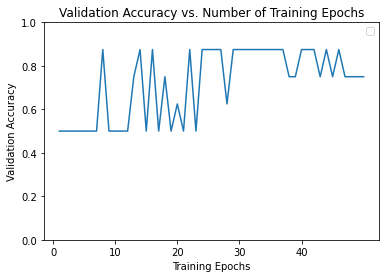

In [ ]:
# Plot the training curves of validation accuracy vs. number of training epochs 
ohist = []
ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist)
plt.ylim((0,1.))
plt.xticks(np.arange(0, num_epochs, 10))
plt.legend()
plt.show()

In [ ]:
#print(model_ft)

## 8. Extract Latent Features from Finetuned Model

In [ ]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [ ]:
# set hook at layer where features should be extracted
model_ft.avgpool.register_forward_hook(get_features('features'))

In [ ]:
# # placeholders
labels = []
pred = []
feats = []

# # placeholder for batch features
features = {}

# # loop through batches
for phase in ['train', 'val']:
  for batch_data in dataloaders_dict[phase]:
    # move to device
    inputs = batch_data["image"].to(device)
    targets = batch_data["label"].to(device)
       
    # forward pass [with feature extraction]
    preds = model_ft(inputs)
    
    # add feats and preds to lists
    labels.append(targets.detach().cpu().numpy())
    feats.append(features['features'].cpu().numpy())

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
feats_ft = np.concatenate(feats)
feats_ft.shape # 2048 features

(40, 2048, 1, 1, 1)

In [ ]:
labels_ft = np.concatenate(labels)
labels_ft.shape

(40,)

In [ ]:
deep_feats = np.squeeze(feats_ft, axis=3)
deep_feats = np.squeeze(deep_feats, axis=2)
deep_feats = np.squeeze(deep_feats, axis=2)

## 9. Write Feature Matrix to csv File

In [ ]:
# merge labels and features into a dataframe
labels = pd.DataFrame(labels_ft, columns=['HCC'])
deep_feats = pd.DataFrame(deep_feats, 
                          columns = ["var%d" % (i + 1) 
                          for i in range(deep_feats.shape[1])])

deep_feats = pd.concat([labels.reset_index(drop=True), deep_feats], axis=1)

# write dataframe to csv
deep_feats.to_csv(os.path.join(results_dir, 'DeepFeatures.csv'), index=False, header=True, sep=',')